In [4]:
import nideconv
import glob
import re

reg = re.compile('.*/(?P<ds>ds-[0-9]+)/.*/sub-(?P<subject>[0-9]+)_task-randomdotmotion_run-(?P<run>[0-9]+)_space-T1w_desc-preproc_desc-(?P<mask>.+)_subroi-(?P<subroi>.+)_roi.csv')
fns = glob.glob('./derivatives/ds-*/extracted_signal/sub-*/func/*.csv')

In [5]:
import pandas as pd

In [6]:
df = []

for fn in fns:
    
    if reg.match(fn):
    
        d = pd.read_csv(fn, index_col=0).mean(1).to_frame('signal')
        meta = reg.match(fn).groupdict()

        for key in meta:
            d[key] = meta[key]

        d.index.name = 'frame'
        d.reset_index()
        d['subject'] = d.apply(lambda row: '{ds}.{subject}'.format(**row.to_dict()), 1)
        
        
        d['mask'] = d.apply(lambda row: '{mask}-{subroi}'.format(**row.to_dict()), 1)
        d.drop('ds', 1, inplace=True)
        df.append(d)
    
df = pd.concat(df)
df = df.pivot_table(index=['subject', 'run', 'frame'], columns='mask', values='signal')

In [7]:
reg = re.compile('.*/(?P<ds>ds-[0-9]+)/.*/sub-(?P<subject>[0-9]+)_task-randomdotmotion_run-(?P<run>[0-9]+)_events.tsv')

In [8]:
events = []
for fn in glob.glob('./derivatives/ds-*/event_files/*.tsv'):
    meta = reg.match(fn).groupdict()
    
    d = pd.read_table(fn)
    
    for key in meta:
        d[key] = meta[key]
    
    d['subject'] = d.apply(lambda row: '{ds}.{subject}'.format(**row.to_dict()), 1)
    d.drop('ds', 1, inplace=True)
    events.append(d.copy())

events = pd.concat(events)


events['original_onset'] = events['onset'].copy()
events['onset'] = events['original_onset'] + 1.5  ## the event_files were shifted by 3 seconds
events = events.rename(columns={'trial_type': 'event_type'})

In [9]:
# events[(events.subject=='ds-02.05') & (events.run == '03')]  # 0.25 seconds difference with 'raw' data?

In [10]:
reg = re.compile('.*/(?P<ds>ds-[0-9]+)/.*/sub-(?P<subject>[0-9]+)_task-randomdotmotion_run-(?P<run>[0-9]+)_desc-confounds_regressors.tsv')

fns = glob.glob('./derivatives/ds-*/fmriprep_confounds/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

confounds = []
for fn in fns:
    meta = reg.match(fn).groupdict()
    d = pd.read_table(fn)
    
    for key in meta:
        d[key] = meta[key]
        
    d['subject'] = d.apply(lambda row: '{ds}.{subject}'.format(**row.to_dict()), 1)
    d.drop('ds', 1, inplace=True)

    confounds.append(d)
    
confounds = pd.concat(confounds)

confounds = confounds.set_index(['subject', 'run'])

In [12]:
events

onset      event_type   subject run  original_onset
0       8.75            hard  ds-02.02  03            7.25
1      17.75            easy  ds-02.02  03           16.25
2      24.50            easy  ds-02.02  03           23.00
3      37.25            hard  ds-02.02  03           35.75
4      46.25            hard  ds-02.02  03           44.75
..       ...             ...       ...  ..             ...
439  1114.25  response_right  ds-01.16  01         1112.75
440  1124.00   response_left  ds-01.16  01         1122.50
441  1133.75  response_right  ds-01.16  01         1132.25
442  1144.25  response_right  ds-01.16  01         1142.75
443  1151.75  response_right  ds-01.16  01         1150.25

[40654 rows x 5 columns]

## Only cue

In [13]:
include_confounds = include = [u'dvars',u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', u'a_comp_cor_05', u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06', u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

events_ = events.copy()
events_ = events_[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_['event_type'] = 'cue'

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds[include_confounds].reset_index())
gf.add_event('cue', interval=[0, 24], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['cue',], ci=95, plots='covariate', col='roi', col_wrap=3)

TypeError: __new__() got an unexpected keyword argument 'labels'

## only ds 01

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

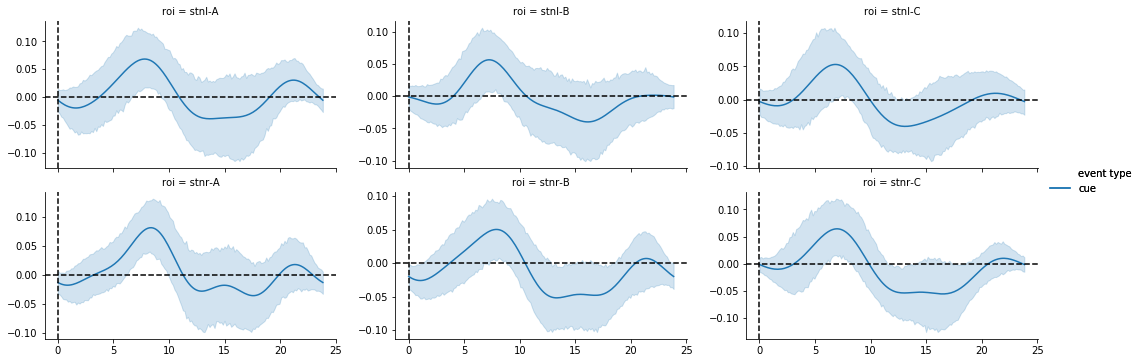

In [9]:
##
include_confounds = include = [u'dvars',u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', u'a_comp_cor_05', u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06', u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

events_ = events.copy()
events_ = events_[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_['event_type'] = 'cue'

confounds_ = confounds[include_confounds].reset_index().copy()

df_ = df.filter(regex='ds-01.*', axis=0)
events_ = events_.loc[events_.subject.str.match('ds-01.*')]
confounds_ = confounds_.loc[confounds_.subject.str.match('ds-01.*')]

gf = nideconv.GroupResponseFitter(df_,
                                  events_, 
                                  1/3., 
                                  confounds=confounds_)

gf.add_event('cue', interval=[0, 24], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['cue',], ci=95, plots='covariate', col='roi', col_wrap=3)

## only DS 02

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

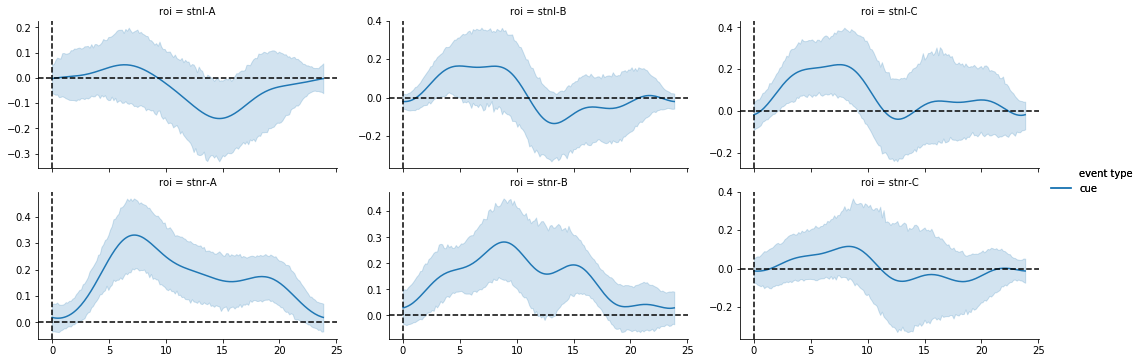

In [10]:
##
include_confounds = include = [u'dvars',u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', u'a_comp_cor_05', u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06', u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

events_ = events.copy()
events_ = events_[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_['event_type'] = 'cue'

confounds_ = confounds[include_confounds].reset_index().copy()

df_ = df.filter(regex='ds-02.*', axis=0)
events_ = events_.loc[events_.subject.str.match('ds-02.*')]
confounds_ = confounds_.loc[confounds_.subject.str.match('ds-02.*')]

gf = nideconv.GroupResponseFitter(df_,
                                  events_, 
                                  1/3., 
                                  confounds=confounds_)

gf.add_event('cue', interval=[0, 24], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['cue',], ci=95, plots='covariate', col='roi', col_wrap=3)

## only stim

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

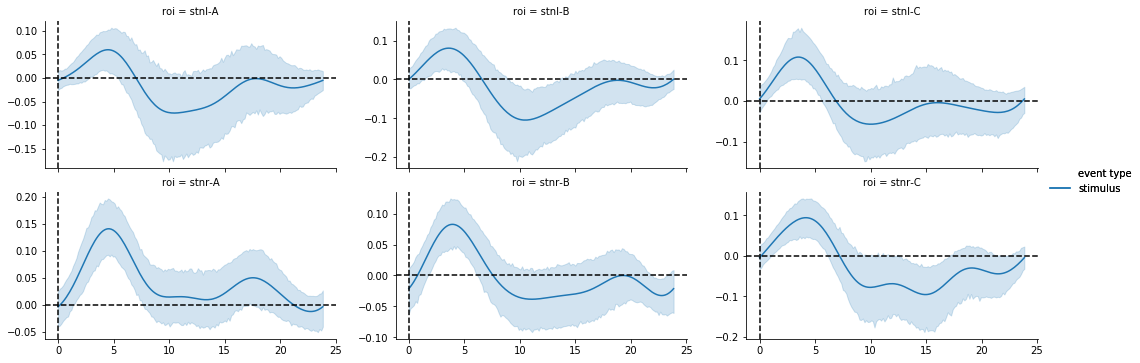

In [11]:
include_confounds = include = [u'dvars',u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', u'a_comp_cor_05', u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06', u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

events_ = events.copy()
events_ = events_[events_['event_type'].isin(['easy', 'hard'])]
events_['event_type'] = 'stimulus'

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds[include_confounds].reset_index())
gf.add_event('stimulus', interval=[0, 24], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['stimulus',], ci=95, plots='covariate', col='roi', col_wrap=3)

## only ds 1

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

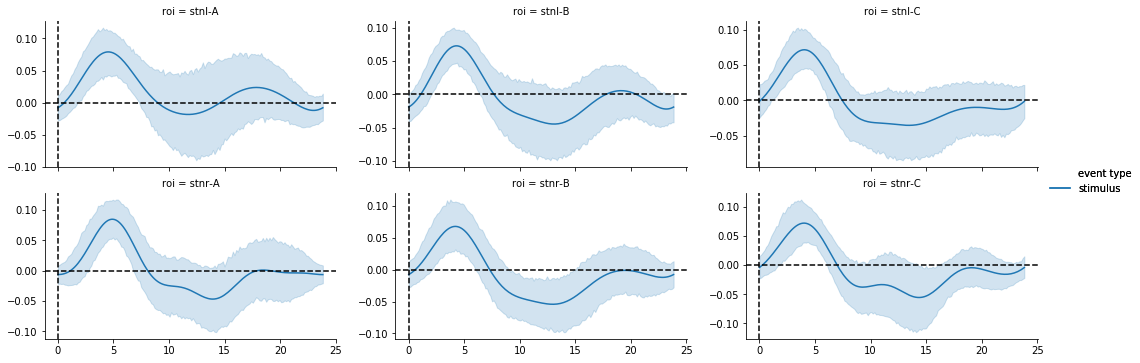

In [12]:
include_confounds = include = [u'dvars',u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', u'a_comp_cor_05', u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06', u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

events_ = events.copy()
events_ = events_[events_['event_type'].isin(['easy', 'hard'])]
events_['event_type'] = 'stimulus'
confounds_ = confounds[include_confounds].reset_index().copy()

df_ = df.filter(regex='ds-01.*', axis=0)
events_ = events_.loc[events_.subject.str.match('ds-01.*')]
confounds_ = confounds_.loc[confounds_.subject.str.match('ds-01.*')]

gf = nideconv.GroupResponseFitter(df_,
                                  events_, 
                                  1/3., 
                                  confounds=confounds_)

gf.add_event('stimulus', interval=[0, 24], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['stimulus',], ci=95, plots='covariate', col='roi', col_wrap=3)

## only ds-02

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

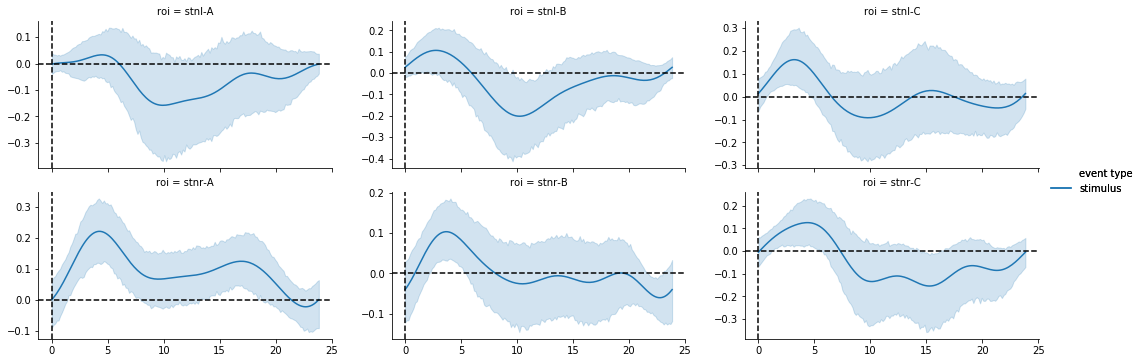

In [13]:
include_confounds = include = [u'dvars',u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', u'a_comp_cor_05', u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06', u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

events_ = events.copy()
events_ = events_[events_['event_type'].isin(['easy', 'hard'])]
events_['event_type'] = 'stimulus'
confounds_ = confounds[include_confounds].reset_index().copy()

df_ = df.filter(regex='ds-02.*', axis=0)
events_ = events_.loc[events_.subject.str.match('ds-02.*')]
confounds_ = confounds_.loc[confounds_.subject.str.match('ds-02.*')]

gf = nideconv.GroupResponseFitter(df_,
                                  events_, 
                                  1/3., 
                                  confounds=confounds_)

gf.add_event('stimulus', interval=[0, 24], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['stimulus'], ci=95, plots='covariate', col='roi', col_wrap=3)

## both stimulus & cue

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

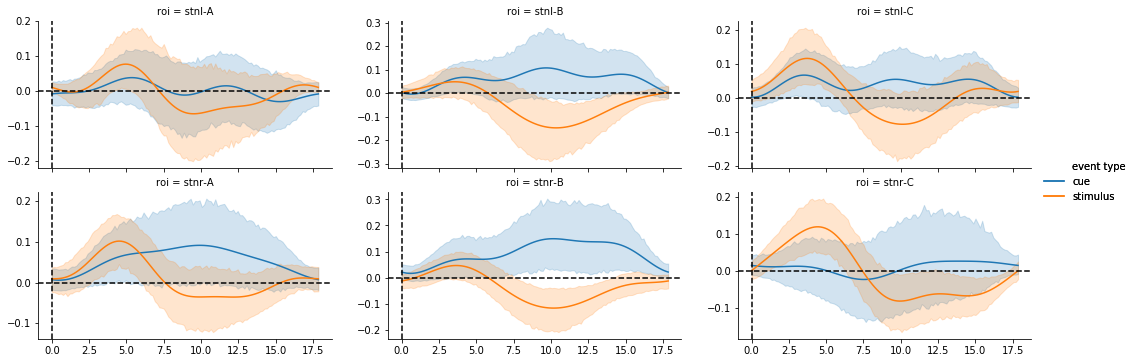

In [14]:
events_ = events.copy()
events_ = events_[events_.event_type.isin(['easy', 'hard', 'cue_neutral', 'cue_left', 'cue_right'])]
events_.loc[events_.event_type.isin(['easy', 'hard']), 'event_type'] = 'stimulus'
events_.loc[events_.event_type.isin(['cue_neutral', 'cue_left', 'cue_right']), 'event_type'] = 'cue'

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds[include_confounds].reset_index())
gf.add_event('stimulus', interval=[0, 18], basis_set='fourier', n_regressors=7)
gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=7)


gf.fit()
gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95, plots='covariate', col='roi', col_wrap=3)

## ds 01

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

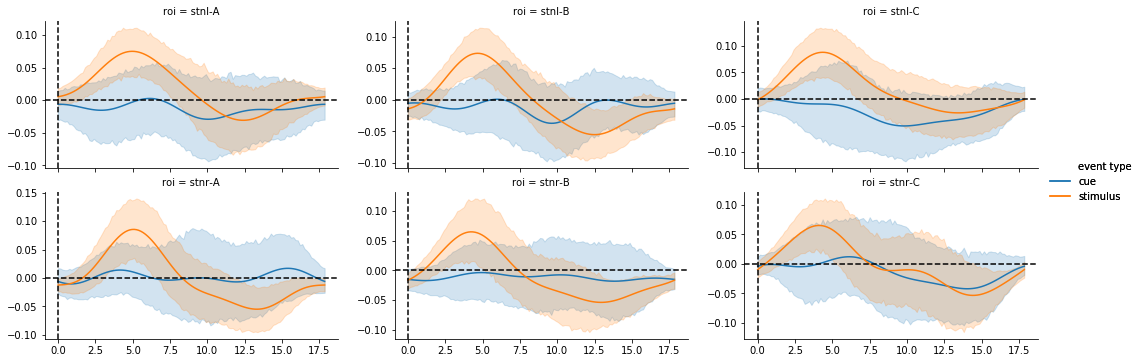

In [15]:
events_ = events.copy()
events_ = events_[events_.event_type.isin(['easy', 'hard', 'cue_neutral', 'cue_left', 'cue_right'])]
events_.loc[events_.event_type.isin(['easy', 'hard']), 'event_type'] = 'stimulus'
events_.loc[events_.event_type.isin(['cue_neutral', 'cue_left', 'cue_right']), 'event_type'] = 'cue'

df_ = df.filter(regex='ds-01.*', axis=0)
events_ = events_.loc[events_.subject.str.match('ds-01.*')]
confounds_ = confounds[include_confounds].reset_index().copy()
confounds_ = confounds_.loc[confounds_.subject.str.match('ds-01.*')]

gf = nideconv.GroupResponseFitter(df_, 
                                  events_, 1/3., 
                                  confounds=confounds_)
gf.add_event('stimulus', interval=[0, 18], basis_set='fourier', n_regressors=7)
gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=7)


gf.fit()
#gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95)
gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95, plots='covariate', col='roi', col_wrap=3)
gf1 = gf

/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

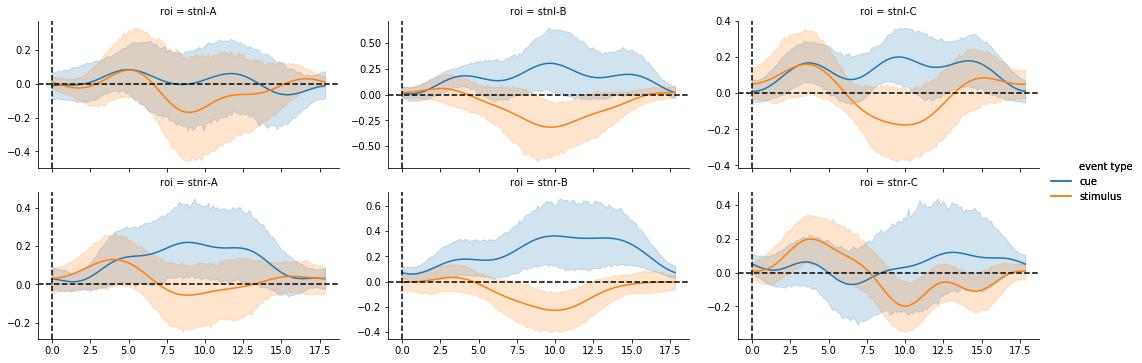

In [38]:
events_ = events.copy()
events_ = events_[events_.event_type.isin(['easy', 'hard', 'cue_neutral', 'cue_left', 'cue_right'])]
events_.loc[events_.event_type.isin(['easy', 'hard']), 'event_type'] = 'stimulus'
events_.loc[events_.event_type.isin(['cue_neutral', 'cue_left', 'cue_right']), 'event_type'] = 'cue'

df_ = df.filter(regex='ds-02.*', axis=0)
events_ = events_.loc[events_.subject.str.match('ds-02.*')]
confounds_ = confounds[include_confounds].reset_index().copy()
confounds_ = confounds_.loc[confounds_.subject.str.match('ds-02.*')]

gf = nideconv.GroupResponseFitter(df_, 
                                  events_, 1/3., 
                                  confounds=confounds_)
gf.add_event('stimulus', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)


gf.fit()
#gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95)
gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95, plots='covariate', col='roi', col_wrap=3)
gf2 = gf

6


/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:453: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.arange(0, len(df.loc[ix]) * TR, TR)
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/stevenm/miniconda3/lib/python3.6/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

4.5
3
1.5
0
-1.5
-3
-4.5
-6


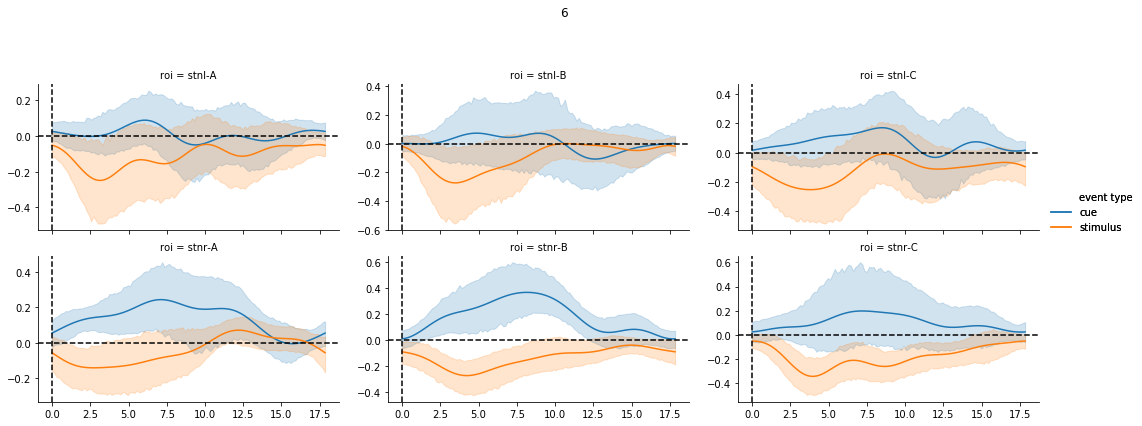

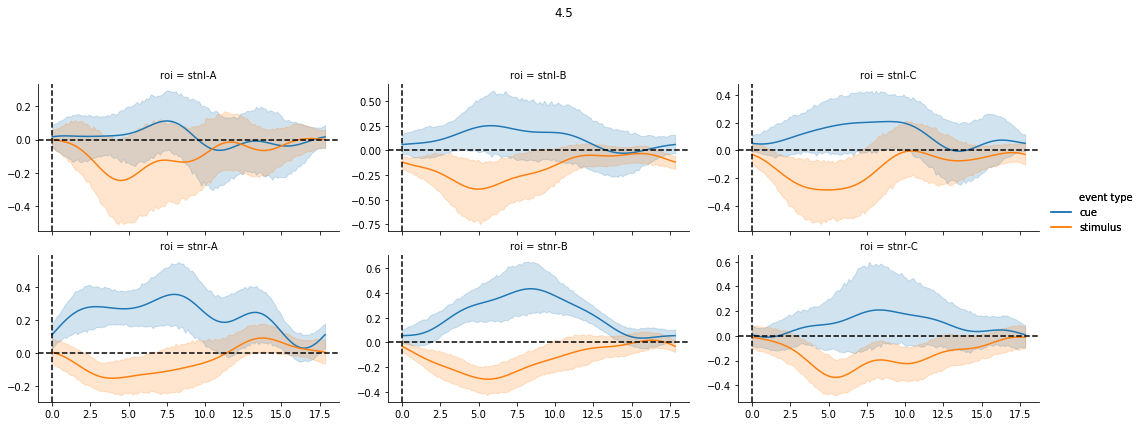

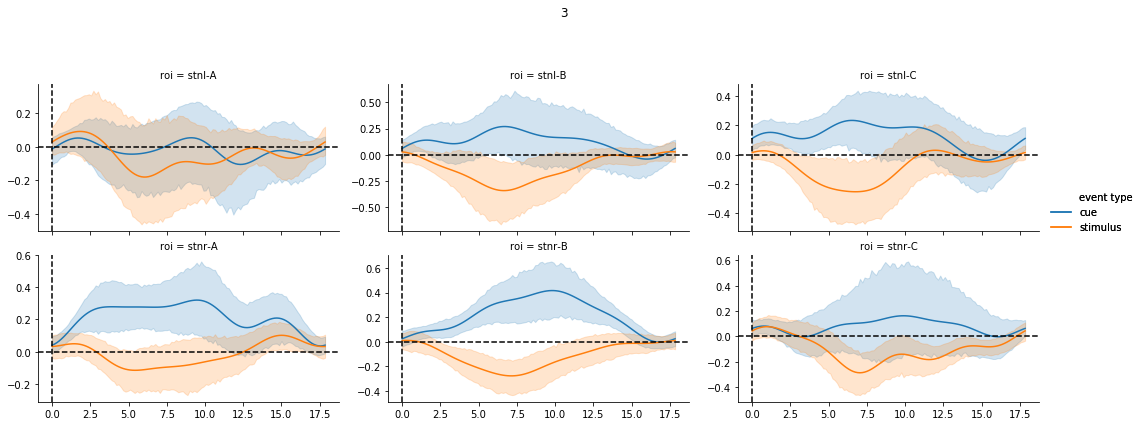

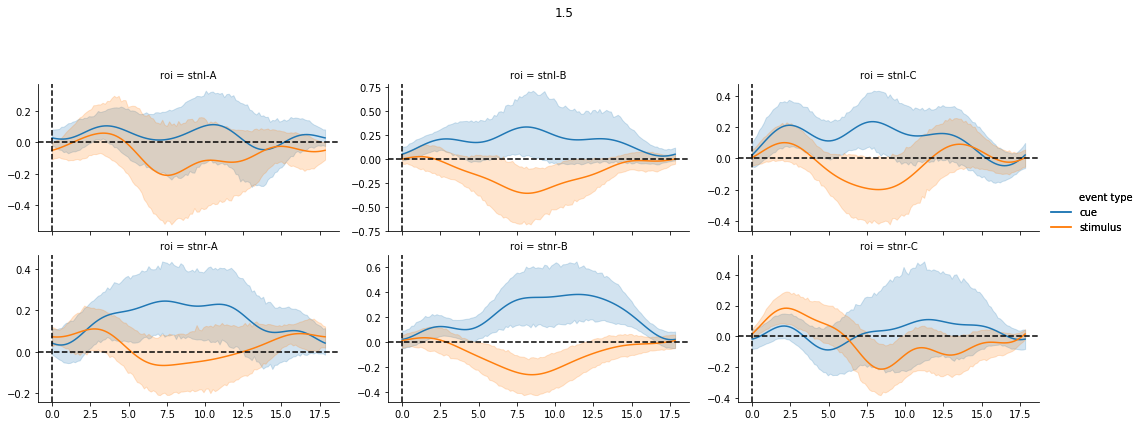

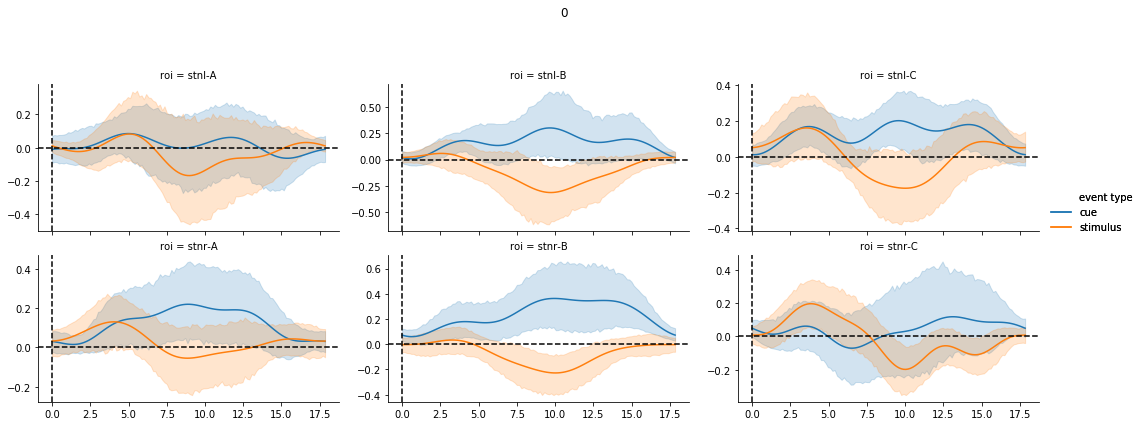

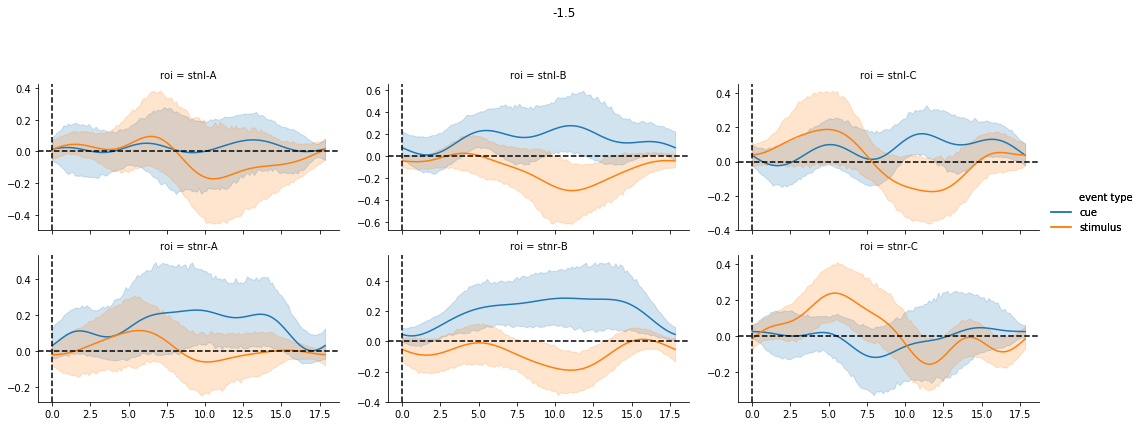

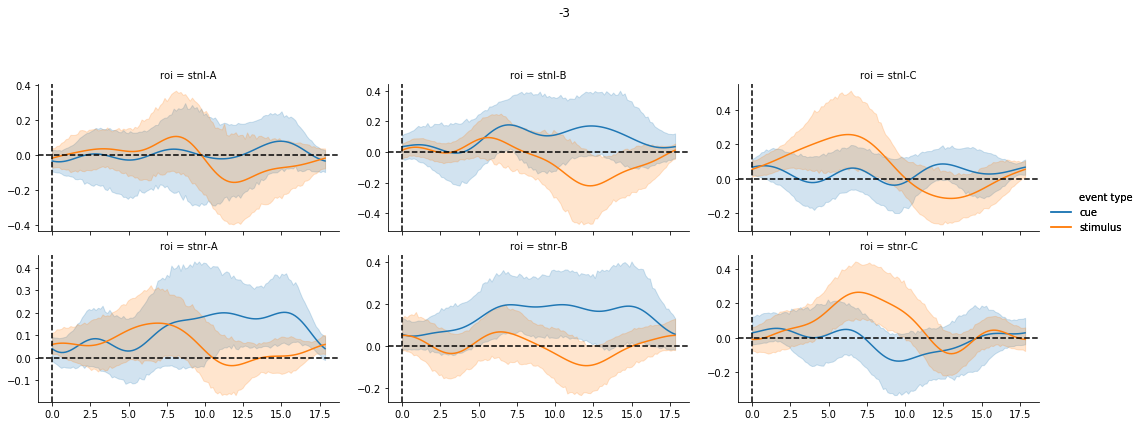

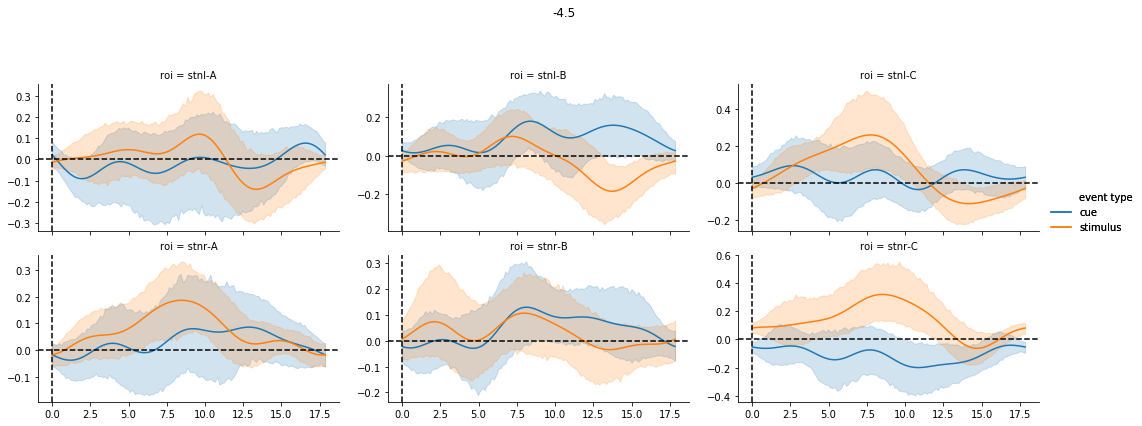

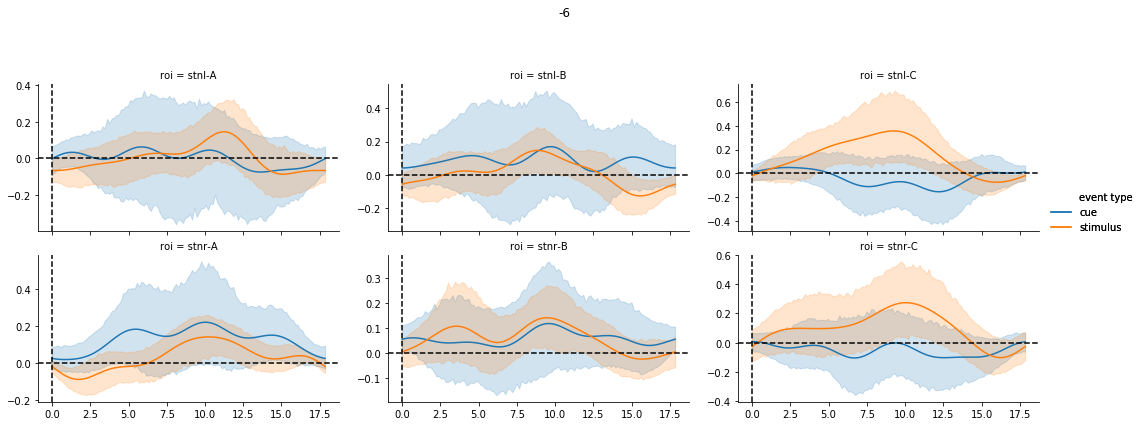

In [46]:
for onset_shift in [6, 4.5, 3, 1.5, 0, -1.5, -3, -4.5, -6]:
    print(onset_shift)
    events_ = events.copy()
    events_ = events_[events_.event_type.isin(['easy', 'hard', 'cue_neutral', 'cue_left', 'cue_right'])]
    events_.loc[events_.event_type.isin(['easy', 'hard']), 'event_type'] = 'stimulus'
    events_.loc[events_.event_type.isin(['cue_neutral', 'cue_left', 'cue_right']), 'event_type'] = 'cue'

    df_ = df.filter(regex='ds-02.*', axis=0)
    events_ = events_.loc[events_.subject.str.match('ds-02.*')]
    events_['onset'] += onset_shift
    confounds_ = confounds[include_confounds].reset_index().copy()
    confounds_ = confounds_.loc[confounds_.subject.str.match('ds-02.*')]

    gf = nideconv.GroupResponseFitter(df_, 
                                      events_, 1/3., 
                                      confounds=confounds_)
    gf.add_event('stimulus', interval=[0, 18], basis_set='fourier', n_regressors=9)
    gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)


    gf.fit()
    #gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95)
    a = gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95, plots='covariate', col='roi', col_wrap=3)
    a[0].fig.suptitle(onset_shift)
    gf2 = gf

## noise estimates? sigma^2?

In [17]:
sigma2s_ds1 = gf1._get_response_fitters().apply(lambda x: x.sigma2)
sigma2s_ds2 = gf2._get_response_fitters().apply(lambda x: x.sigma2)

In [18]:
sigma2s_ds1

mask        stnl-A    stnl-B    stnl-C    stnr-A    stnr-B    stnr-C
subject                                                             
ds-01.01  0.216667  0.250735  0.398621  0.226189  0.275246  0.223176
ds-01.02  0.277491  0.257938  0.190310  0.276752  0.181705  0.214313
ds-01.03  0.287947  0.346757  0.288240  0.252353  0.263764  0.265478
ds-01.04  0.270115  0.303816  0.391749  0.302924  0.244863  0.289002
ds-01.05  0.350136  0.351782  0.348785  0.392721  0.360086  0.326131
ds-01.06  0.246423  0.319107  0.322053  0.239721  0.242097  0.392233
ds-01.07  0.313138  0.330545  0.404632  0.311361  0.306009  0.361718
ds-01.08  0.503231  0.431421  0.429328  0.301142  0.434137  0.460271
ds-01.09  0.251241  0.271278  0.334991  0.381428  0.333803  0.276053
ds-01.10  0.400400  0.405662  0.405313  0.231927  0.198971  0.178434
ds-01.11  0.316142  0.386405  0.430007  0.391970  0.401436  0.337869
ds-01.12  0.286515  0.252444  0.401709  0.209828  0.316216  0.398214
ds-01.13  0.376379  0.310553  0.317543  0.477721  0.446873  0.418258
ds-01.14  0.442728  0.385146  0.452072  0.403453  0.389485  0.419536
ds-01.15  0.377606  0.375707  0.356668  0.370882  0.407701  0.489307
ds-01.16  0.299991  0.372564  0.402865  0.341970  0.358938  0.435565
ds-01.17  0.214440  0.207765  0.233501  0.257719  0.268852  0.397507
ds-01.18  0.248666  0.200036  0.250181  0.268246  0.345358  0.291491
ds-01.19  0.246512  0.302917  0.276257  0.253158  0.196133  0.239766

In [19]:
sigma2s_ds2

mask        stnl-A    stnl-B     stnl-C    stnr-A    stnr-B     stnr-C
subject                                                               
ds-02.01  2.868976  6.153728   4.367143  2.917223  2.720295   2.773470
ds-02.02  1.043273  1.519804   1.486785  1.862970  1.509693   1.070365
ds-02.03  1.659698  2.075715   9.246157  1.152292  1.884721   3.202909
ds-02.05  1.520659  2.258892   2.448422  2.393021  1.613537   2.085668
ds-02.06  2.350744  3.793292   4.596909  6.693852  4.475446   1.886745
ds-02.07  3.814416  5.652666   3.850934  2.454035  2.753744   2.447874
ds-02.08  0.841023  1.125989   1.435825  0.723897  0.945763   1.071706
ds-02.09  0.932479  2.486352   3.349781  0.547757  0.658750   0.774907
ds-02.10  0.628587  0.736643   0.845267  0.620476  0.856532   0.722195
ds-02.11  0.773477  1.144794   0.738792  0.830330  1.107592   1.138761
ds-02.12  5.017390  9.398298  10.522763  8.985988  8.248295  10.190520
ds-02.13  1.330288  0.919965   1.837645  1.150223  1.293125   1.855498
ds-02.14  0.879241  0.886782   1.120233  0.679757  0.697339   0.743228
ds-02.15  2.008456  2.526185   2.898850  3.370831  1.550000   1.679164

In [20]:
rsq_ds1 = gf1._get_response_fitters().apply(lambda x: x.get_rsq().iloc[0])
display(rsq_ds1)
rsq_ds2 = gf2._get_response_fitters().apply(lambda x: x.get_rsq().iloc[0])
display(rsq_ds2)

mask        stnl-A    stnl-B    stnl-C    stnr-A    stnr-B    stnr-C
subject                                                             
ds-01.01  0.338539  0.220261  0.420156  0.295260  0.239616  0.150857
ds-01.02  0.422134  0.360985  0.466234  0.228791  0.521256  0.403911
ds-01.03  0.318695  0.148284  0.311004  0.340248  0.403989  0.437080
ds-01.04  0.467604  0.428829  0.310627  0.486028  0.418433  0.319517
ds-01.05  0.534516  0.468757  0.421961  0.286278  0.422445  0.501848
ds-01.06  0.603131  0.611306  0.591687  0.550956  0.267467  0.273400
ds-01.07  0.241379  0.212637  0.201989  0.151248  0.200442  0.192767
ds-01.08  0.233880  0.285495  0.374934  0.274352  0.212785  0.199961
ds-01.09  0.509257  0.460163  0.352960  0.322152  0.413691  0.261423
ds-01.10  0.278476  0.357167  0.342368  0.218571  0.312520  0.402241
ds-01.11  0.408990  0.361618  0.352220  0.228064  0.228721  0.248174
ds-01.12  0.508496  0.312772  0.322138  0.504322  0.533357  0.349780
ds-01.13  0.184119  0.287322  0.207537  0.174106  0.275761  0.200033
ds-01.14  0.152760  0.179294  0.166427  0.208023  0.233176  0.150617
ds-01.15  0.375351  0.460778  0.341515  0.247048  0.247225  0.290588
ds-01.16  0.284189  0.184436  0.296668  0.281445  0.349239  0.319999
ds-01.17  0.432229  0.307643  0.560091  0.330775  0.516995  0.156318
ds-01.18  0.525918  0.340468  0.313487  0.440744  0.365852  0.316230
ds-01.19  0.377916  0.197684  0.343216  0.488993  0.339614  0.408850

mask        stnl-A    stnl-B    stnl-C    stnr-A    stnr-B    stnr-C
subject                                                             
ds-02.01  0.361175  0.311219  0.347826  0.525723  0.437210  0.320541
ds-02.02  0.367357  0.396718  0.542187  0.326572  0.432906  0.652293
ds-02.03  0.606193  0.387998  0.559616  0.653841  0.849734  0.334660
ds-02.05  0.233276  0.412222  0.359676  0.738458  0.552267  0.321928
ds-02.06  0.310473  0.482075  0.278036  0.367087  0.533705  0.324054
ds-02.07  0.428502  0.396729  0.307350  0.755423  0.761258  0.523086
ds-02.08  0.180699  0.415904  0.601684  0.213508  0.137551  0.181515
ds-02.09  0.495485  0.389613  0.355721  0.340201  0.222424  0.253945
ds-02.10  0.242376  0.258979  0.490950  0.262883  0.445570  0.304044
ds-02.11  0.278449  0.490490  0.336544  0.216756  0.265036  0.132454
ds-02.12  0.432775  0.487702  0.185383  0.274595  0.228342  0.278324
ds-02.13  0.223744  0.381789  0.240497  0.702852  0.645735  0.676636
ds-02.14  0.314119  0.700590  0.712749  0.374621  0.335805  0.559072
ds-02.15  0.523917  0.247896  0.509139  0.260099  0.204624  0.486069

In [21]:
rsq_ds1.mean()

mask
stnl-A    0.378820
stnl-B    0.325574
stnl-C    0.352485
stnr-A    0.318811
stnr-B    0.342241
stnr-C    0.293873
dtype: float64

In [22]:
rsq_ds2.mean()

mask
stnl-A    0.357039
stnl-B    0.411423
stnl-C    0.416240
stnr-A    0.429473
stnr-B    0.432298
stnr-C    0.382044
dtype: float64

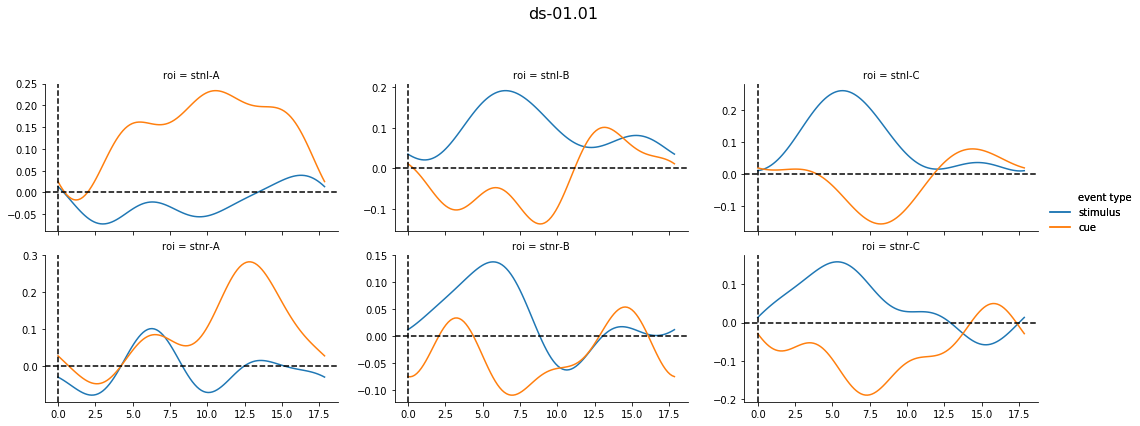

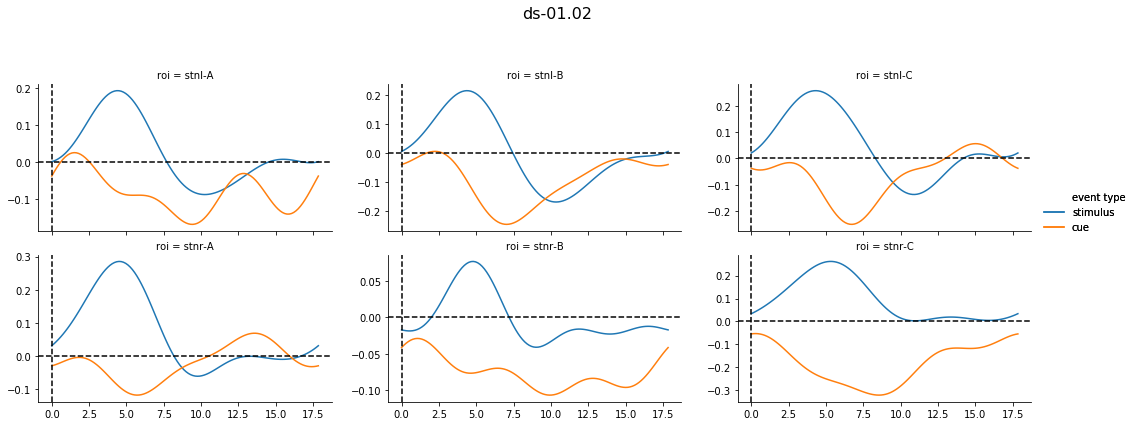

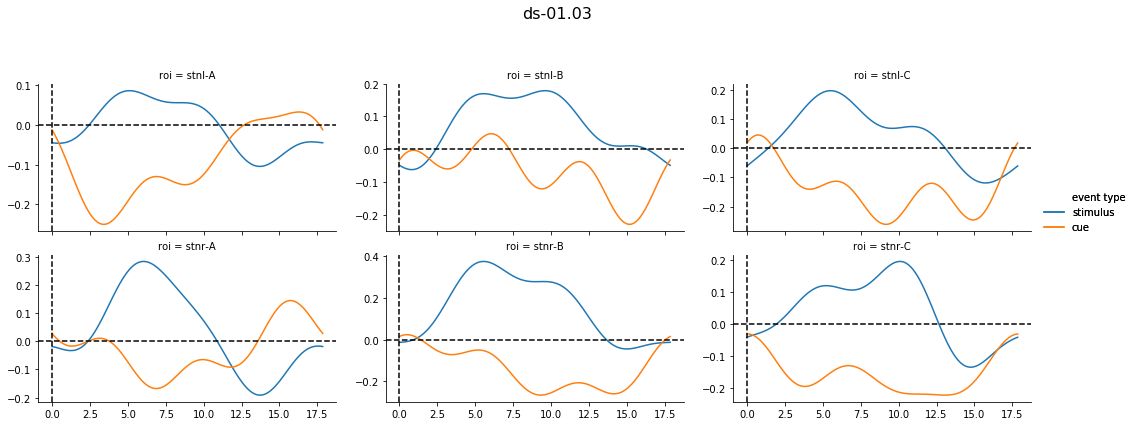

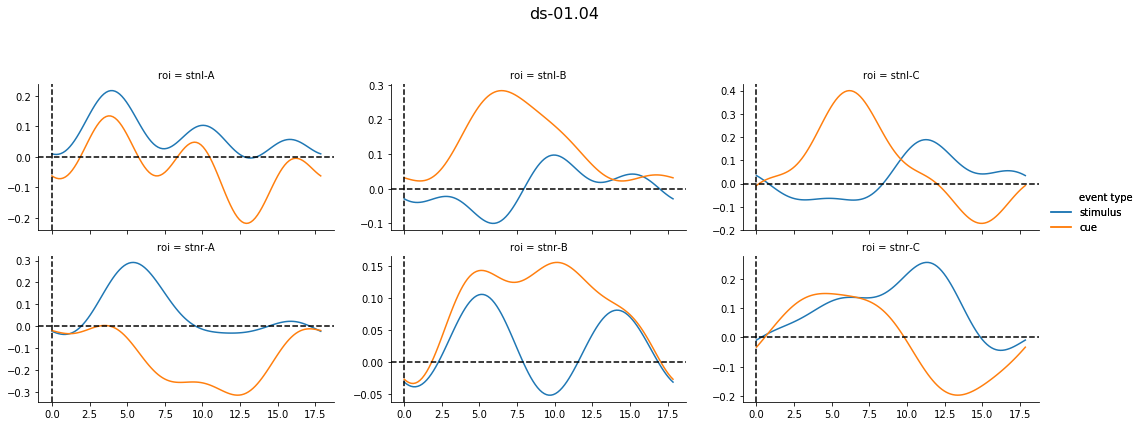

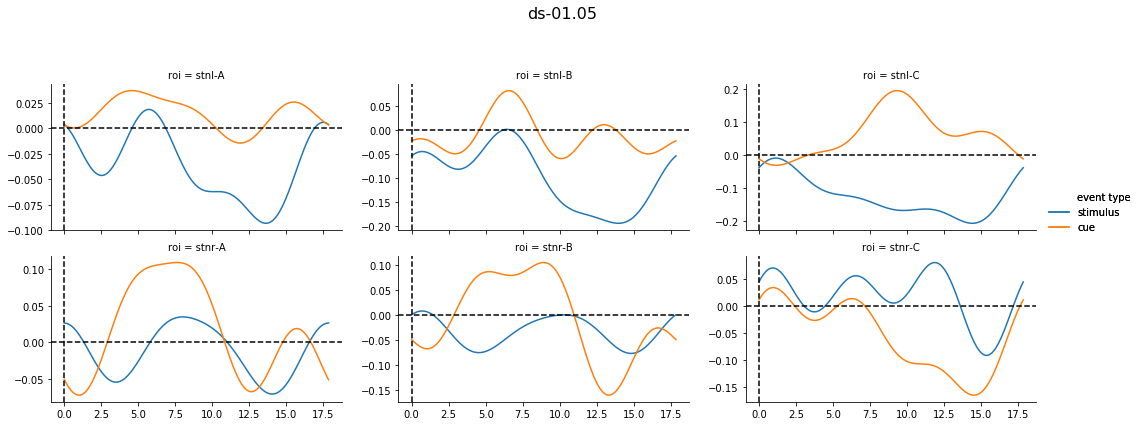

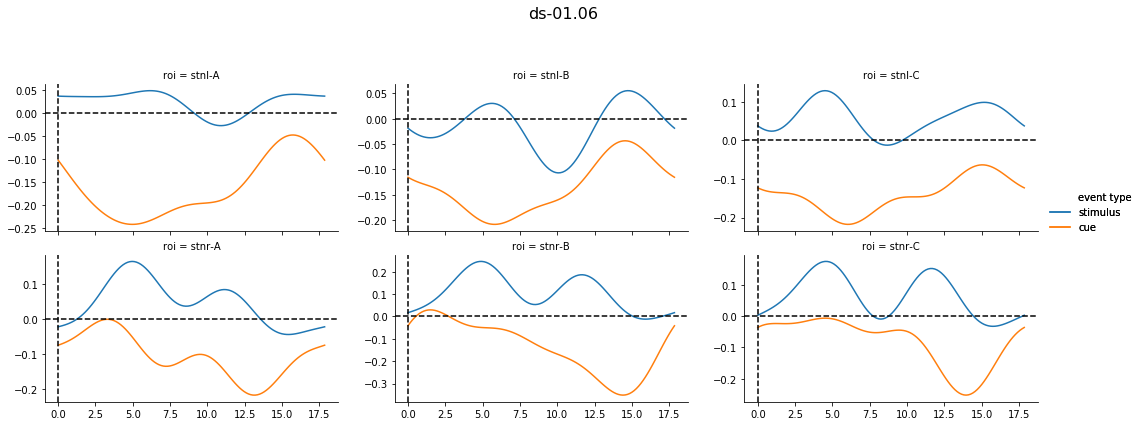

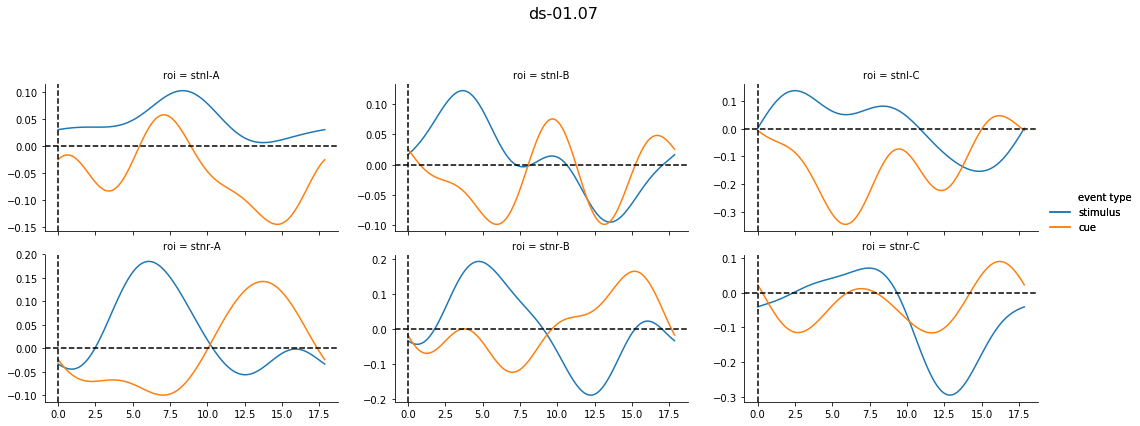

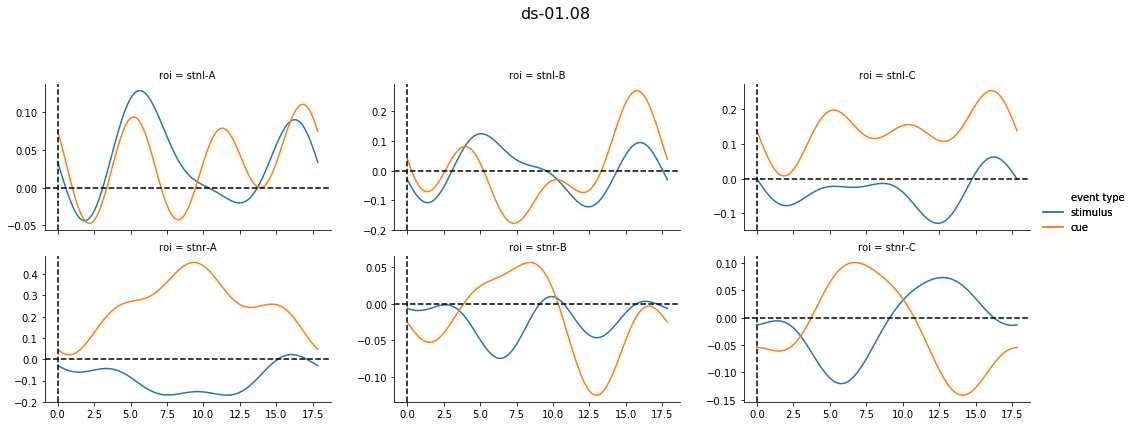

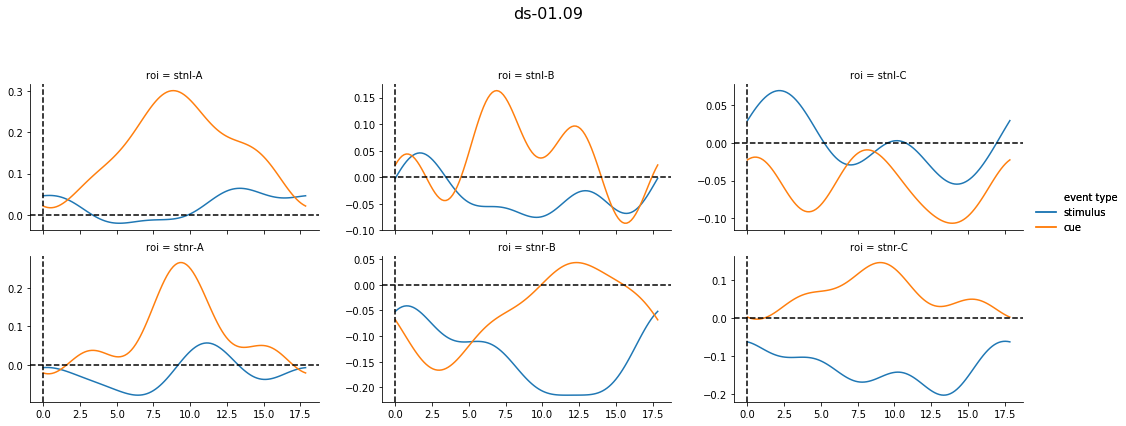

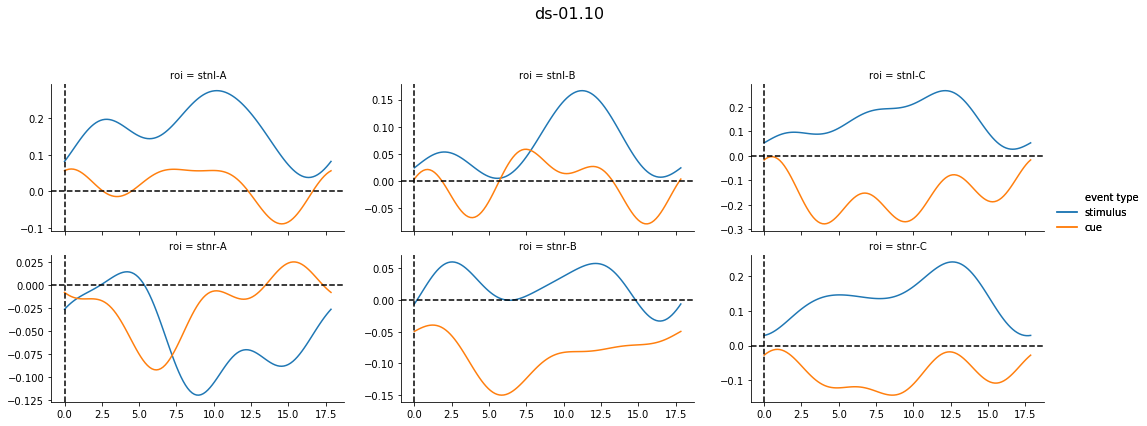

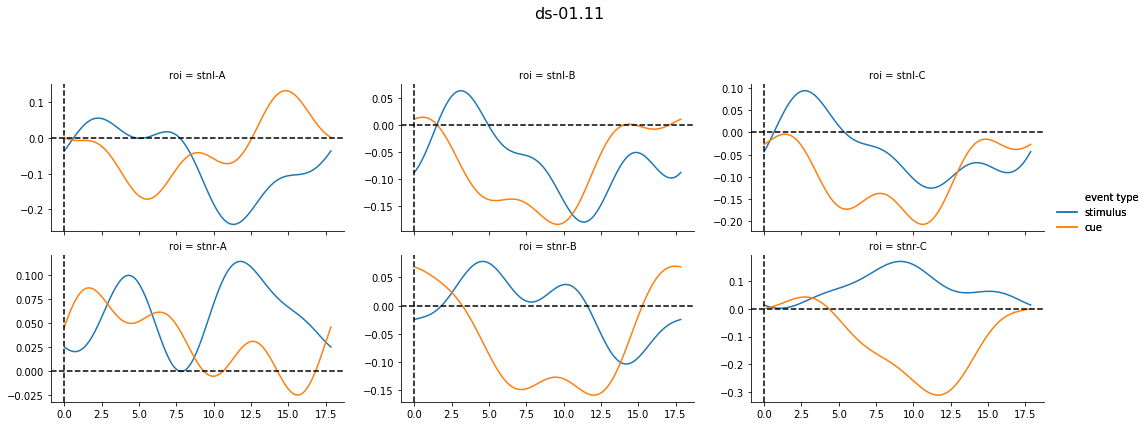

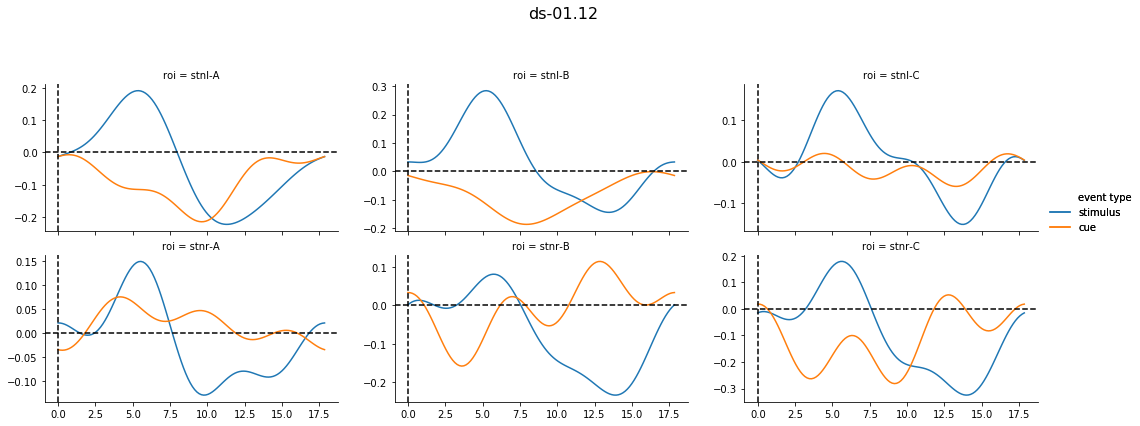

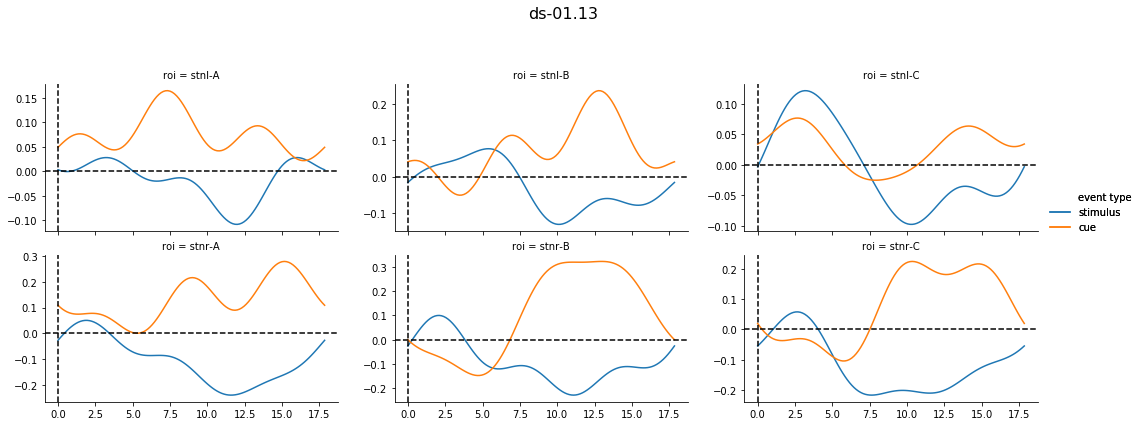

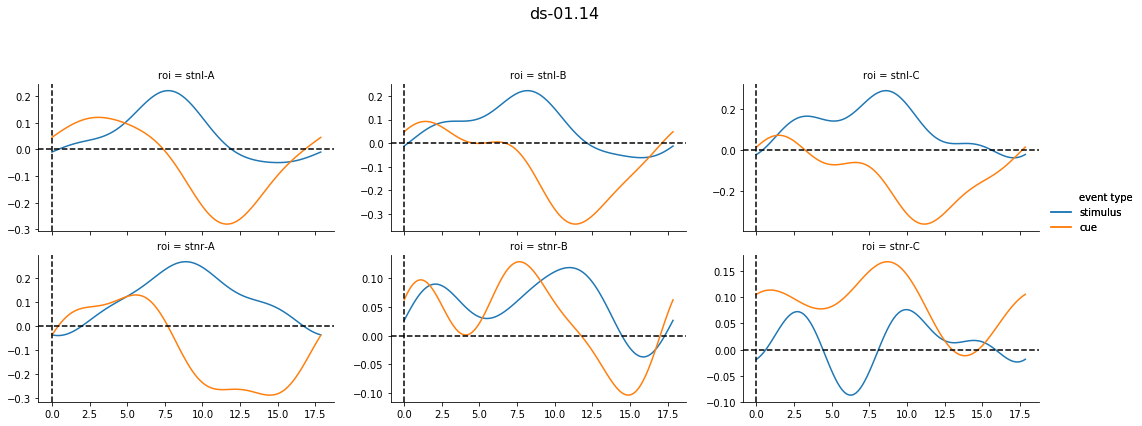

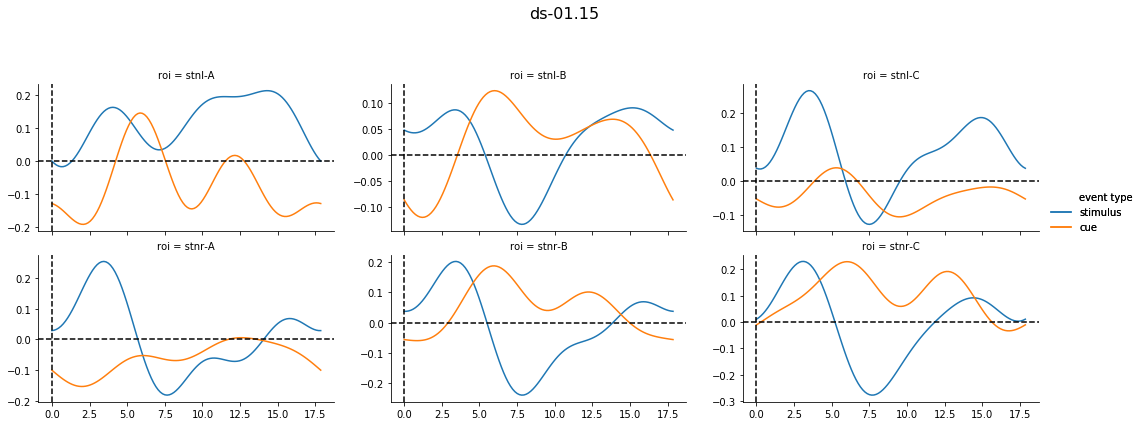

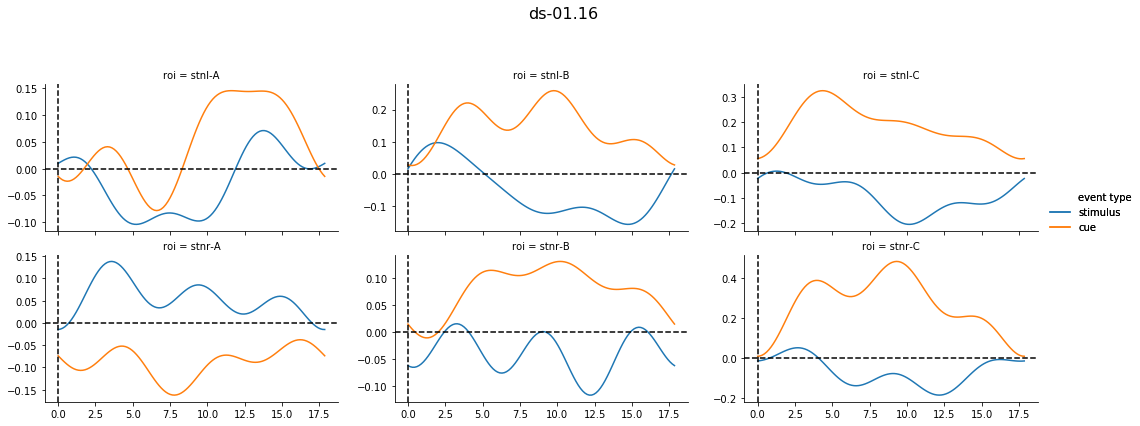

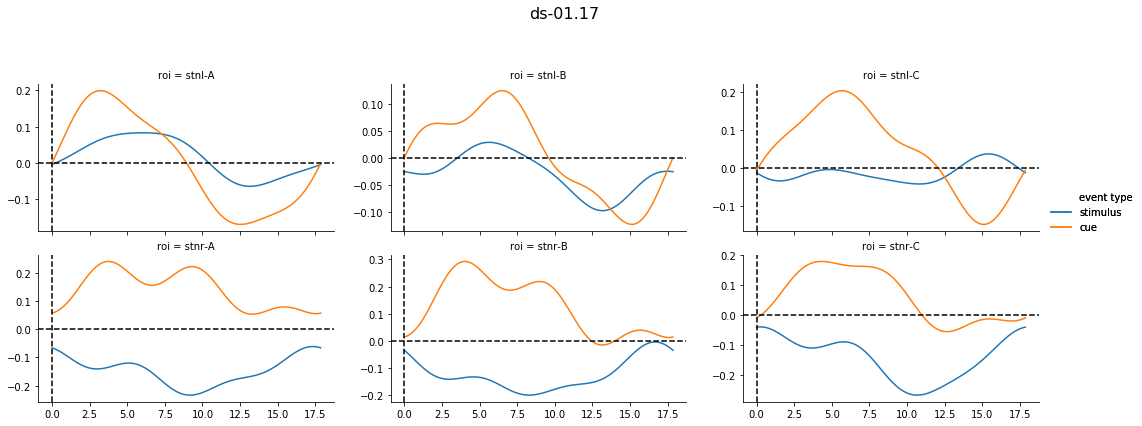

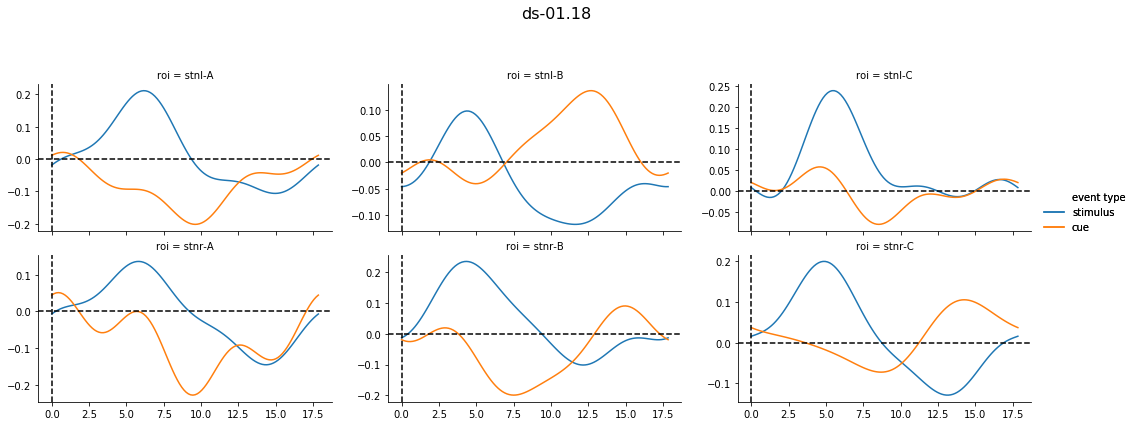

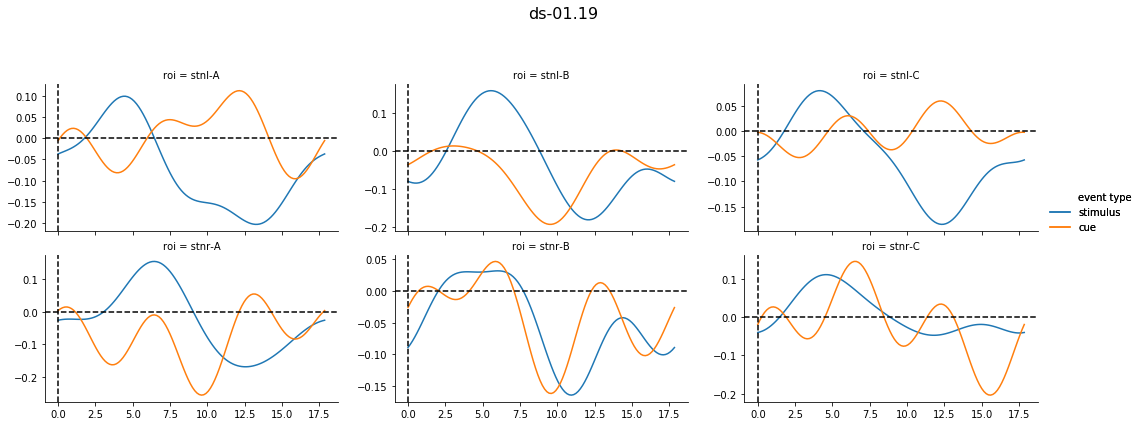

In [23]:
gf1.plot_subject_timecourses(plots='subject', col='roi', col_wrap=3)

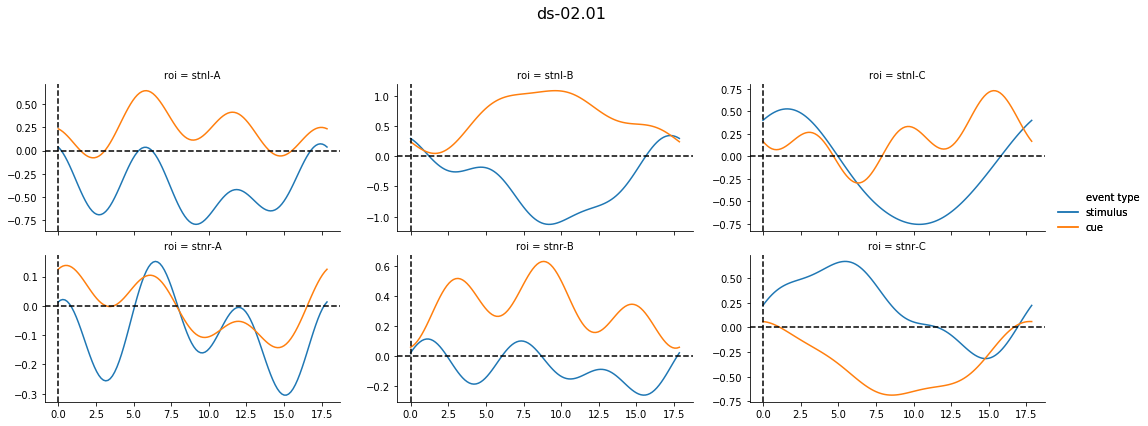

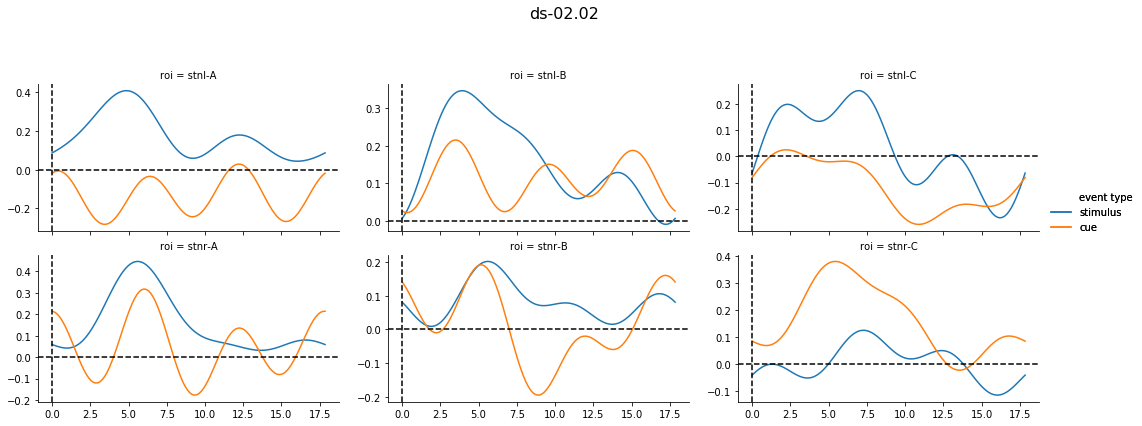

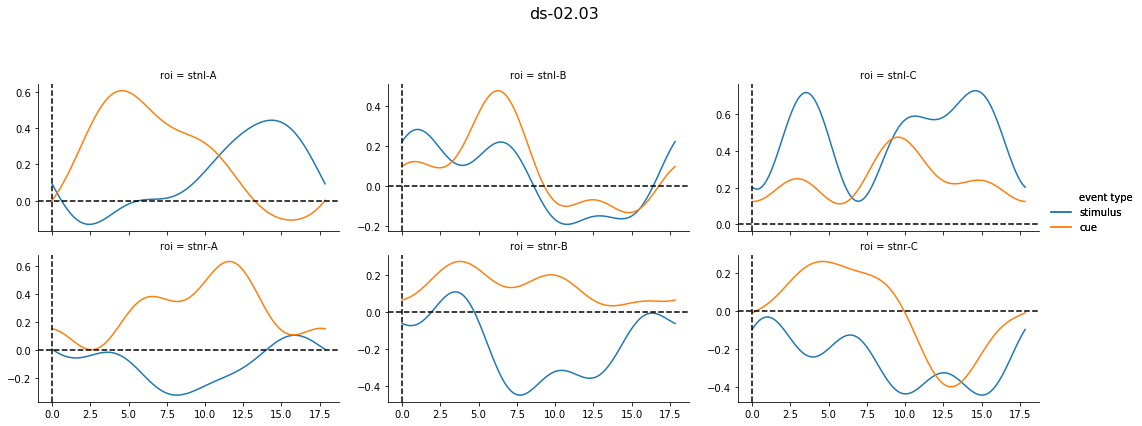

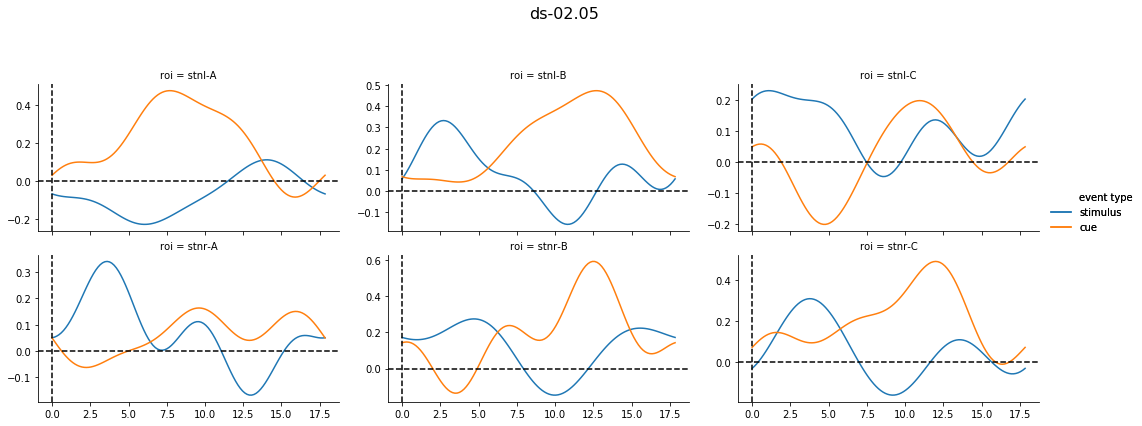

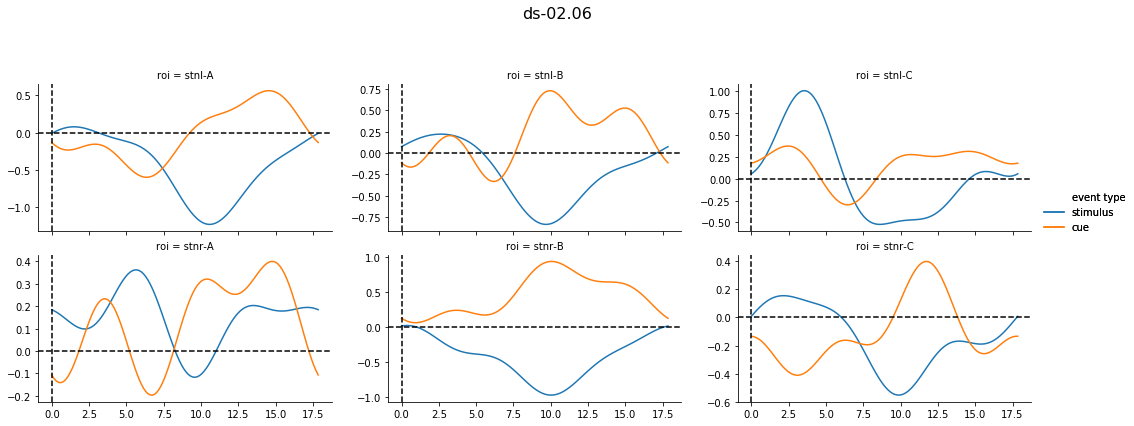

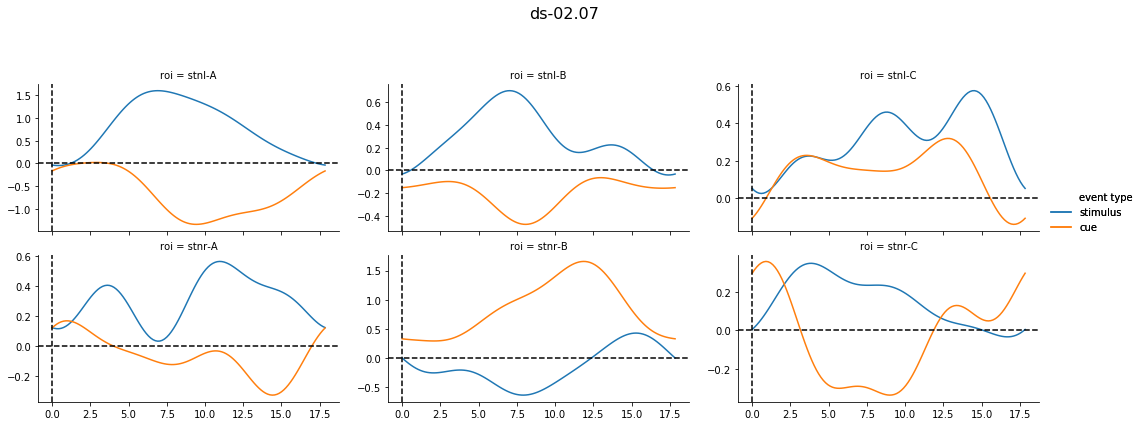

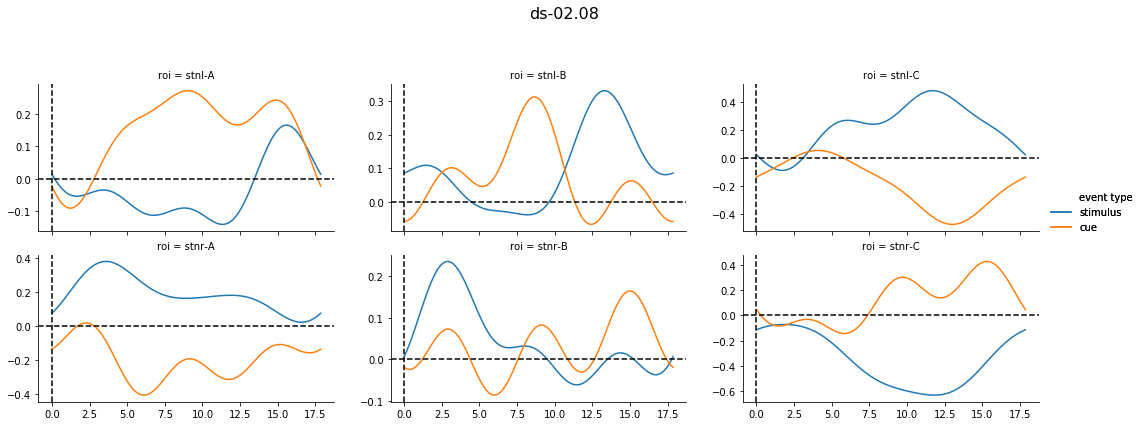

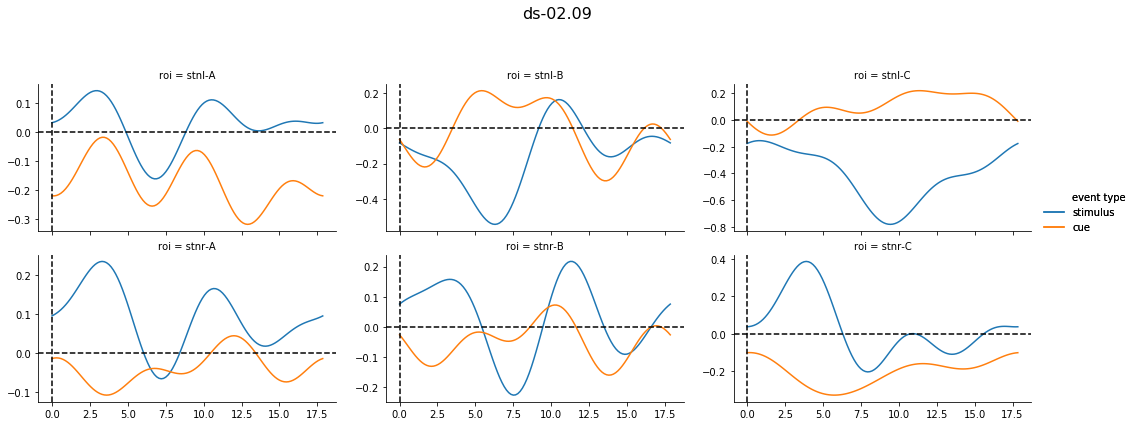

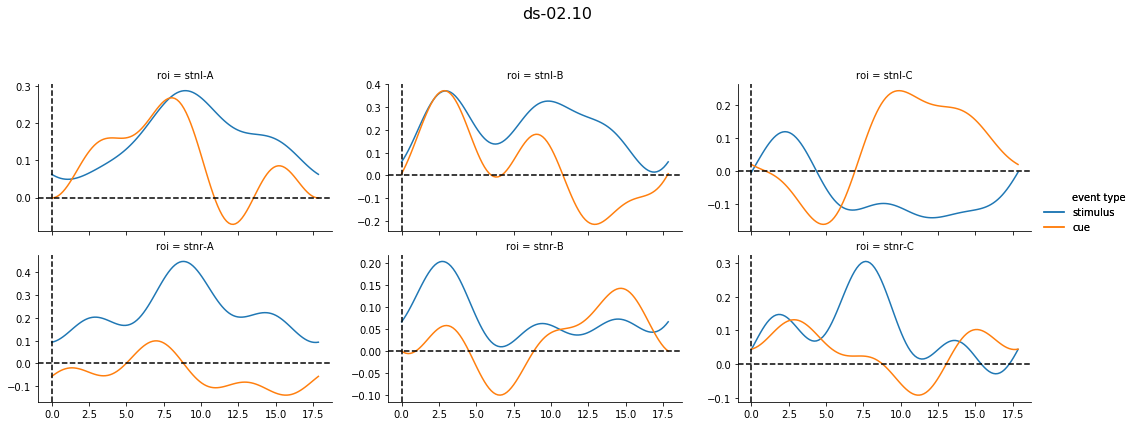

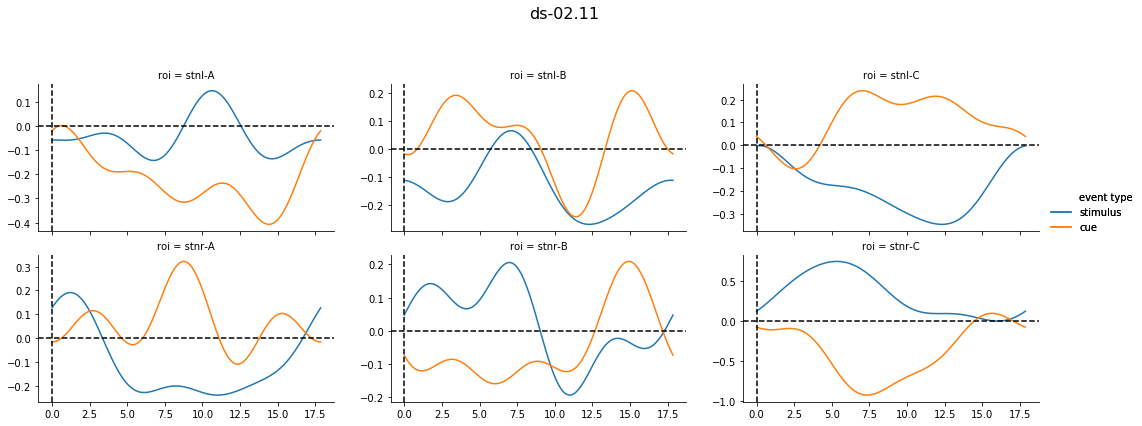

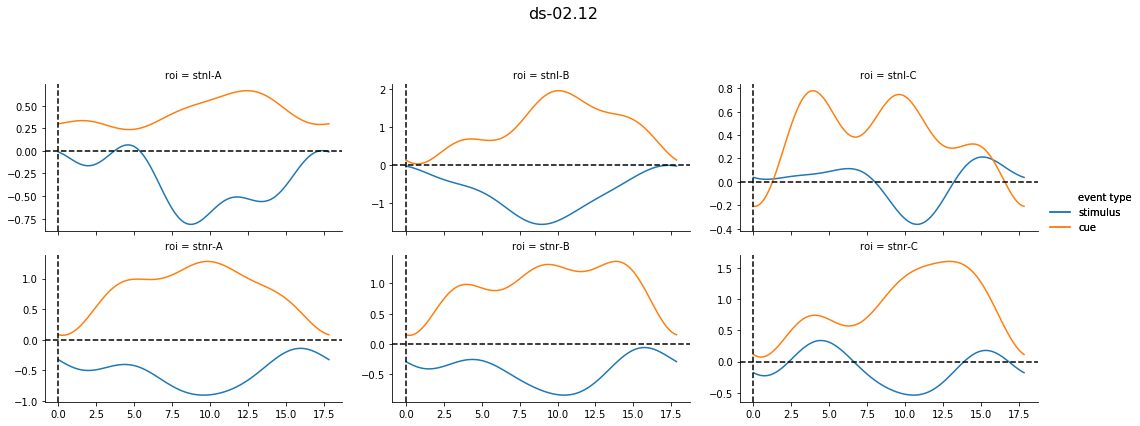

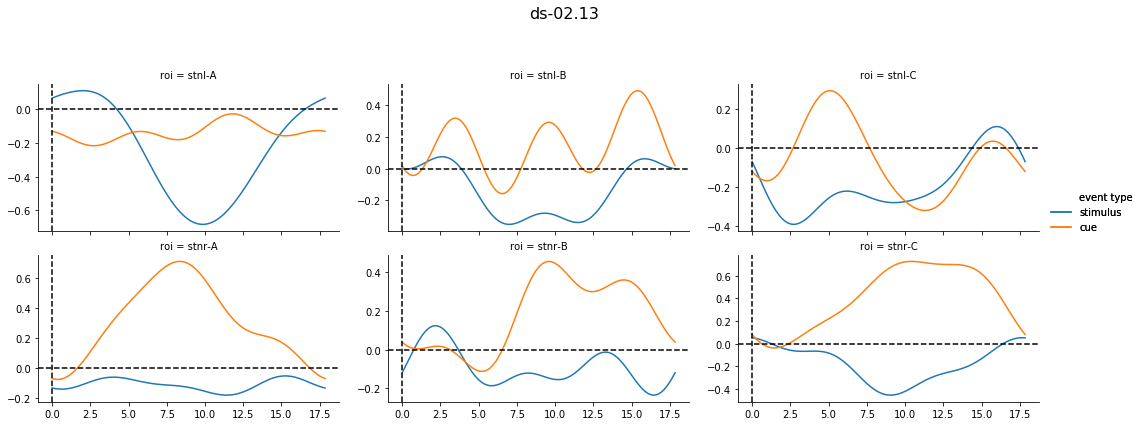

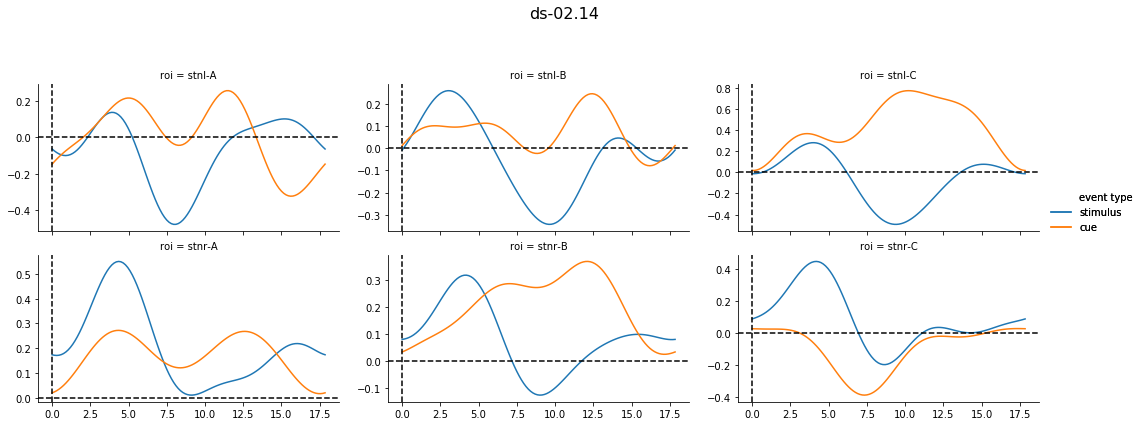

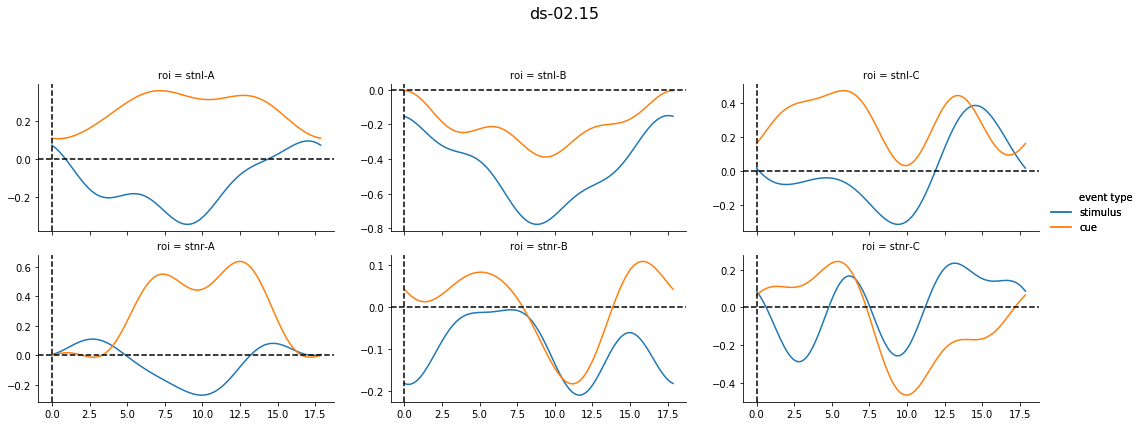

In [24]:
gf2.plot_subject_timecourses(plots='subject', col='roi', col_wrap=3)

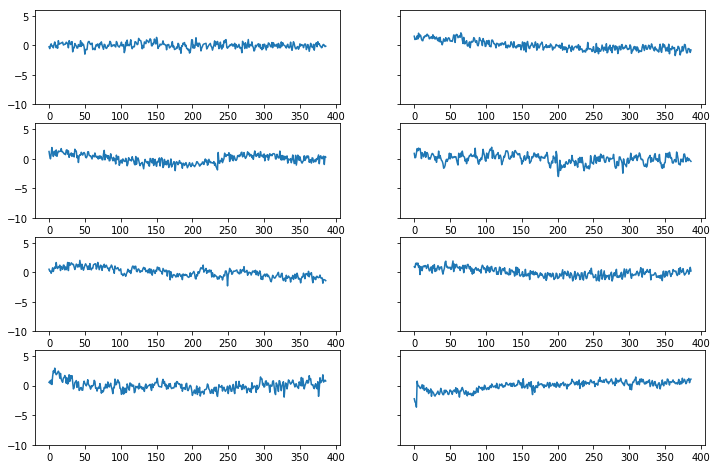

In [26]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(4,2, sharey=True)
ax[0,0].plot(df.loc[('ds-01.01', '01')]['stnl-A'])
ax[0,1].plot(df.loc[('ds-01.02', '01')]['stnl-A'])
ax[1,0].plot(df.loc[('ds-01.04', '01')]['stnl-A'])
ax[1,1].plot(df.loc[('ds-01.05', '01')]['stnl-A'])
ax[2,0].plot(df.loc[('ds-01.06', '01')]['stnl-A'])
ax[2,1].plot(df.loc[('ds-01.07', '01')]['stnl-A'])
ax[3,0].plot(df.loc[('ds-01.08', '01')]['stnl-A'])
ax[3,1].plot(df.loc[('ds-01.09', '01')]['stnl-A'])
    
ax[0,0].set_ylim(-10, 6)
f.set_size_inches(12,8)

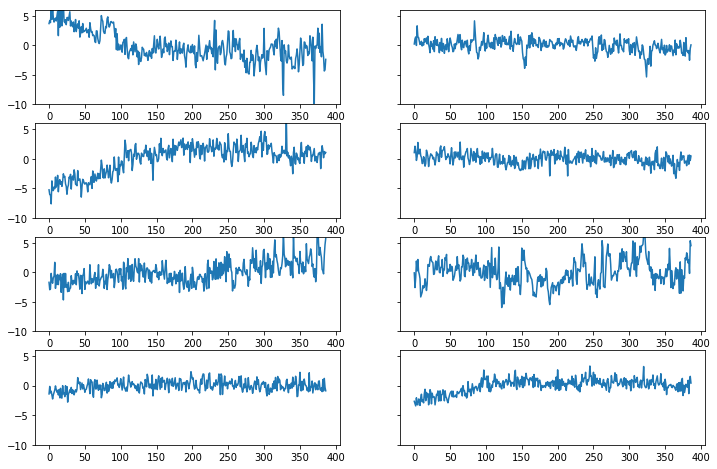

In [27]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(4,2, sharey=True)
ax[0,0].plot(df.loc[('ds-02.01', '01')]['stnl-A'])
ax[0,1].plot(df.loc[('ds-02.02', '01')]['stnl-A'])
ax[1,0].plot(df.loc[('ds-02.03', '01')]['stnl-A'])
ax[1,1].plot(df.loc[('ds-02.05', '01')]['stnl-A'])
ax[2,0].plot(df.loc[('ds-02.06', '01')]['stnl-A'])
ax[2,1].plot(df.loc[('ds-02.07', '01')]['stnl-A'])
ax[3,0].plot(df.loc[('ds-02.08', '01')]['stnl-A'])
ax[3,1].plot(df.loc[('ds-02.09', '01')]['stnl-A'])
ax[0,0].set_ylim(-10, 6)
f.set_size_inches(12,8)

it appears we have some stronger drifts in DS2 (look at the y-scale), which could explain why r^2 is a bit higher (drifts lead to large variance, which can be explained by the set of cosines)

Maybe highpass filter instead of cosines?

## what happens if we do this Bayesian? Measurement noise should be taken into account
One ROI at a time

In [10]:
from nideconv.hierarchical_bayes import HierarchicalBayesianModel

/home/stevenm/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:397: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/stevenm/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


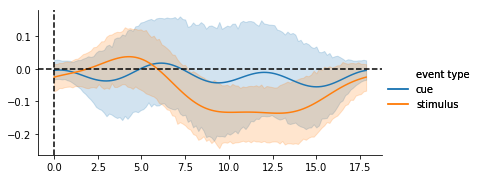

In [8]:
stn_ra = df['stnr-A']

events_ = events.copy()
events_ = events_[events_.event_type.isin(['easy', 'hard', 'cue_neutral', 'cue_left', 'cue_right'])]
events_.loc[events_.event_type.isin(['easy', 'hard']), 'event_type'] = 'stimulus'
events_.loc[events_.event_type.isin(['cue_neutral', 'cue_left', 'cue_right']), 'event_type'] = 'cue'

# fill confounds NaN
#confounds_ = confounds[include_confounds].reset_index().fillna(0)
# no confounds; too many parameters...

gf = nideconv.GroupResponseFitter(stn_ra, events_, 1/3.)#, confounds=confounds_)
gf.add_event('stimulus', interval=[0, 18], basis_set='fourier', n_regressors=7)
gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=7)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['cue', 'stimulus'], ci=95, plots='covariate', col='roi')

#


In [11]:
bgf = HierarchicalBayesianModel.from_groupresponsefitter(gf)

bgf.build_model()
#bgf.sample()

In [ ]:
bgf.sample()

In [ ]:
bgf.plot_group_timecourses()

In [ ]:
bgf.plot_subject_timecourses(col_wrap=3, legend=False)

In [ ]:
bgf.plot_groupwise_timecourses()

In [ ]:
print('hi')